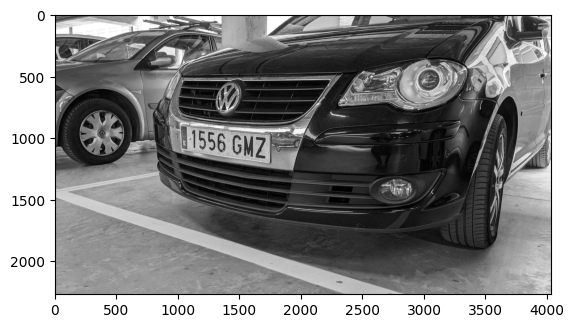

In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import os
from skimage.segmentation import clear_border
import os
from sklearn.model_selection import train_test_split

path = os.getcwd()+"\\Imatges"

nom_imagenes = os.listdir(path)
imagenes = []
imagenes_b = []
ll_img = []

for titulo in nom_imagenes:
    
    if titulo.endswith('.jpg') or titulo.endswith('.jpeg'):
        img =  cv.imread('Imatges/' + titulo)
        ll_img.append(img)
        img_gris = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        b,g,r = cv.split(img)
        imagenes_b.append(b*0.6>img_gris)
        imagenes.append( img_gris)
       
Train=imagenes[:-6]
Test= imagenes[-6:]
#img = cv.imread('Imatges/matricula_28.jpeg')
#img_gris = cv.cvtColor(imagenes[0], cv.COLOR_BGR2GRAY)
plt.imshow(imagenes[0], cmap="gray")

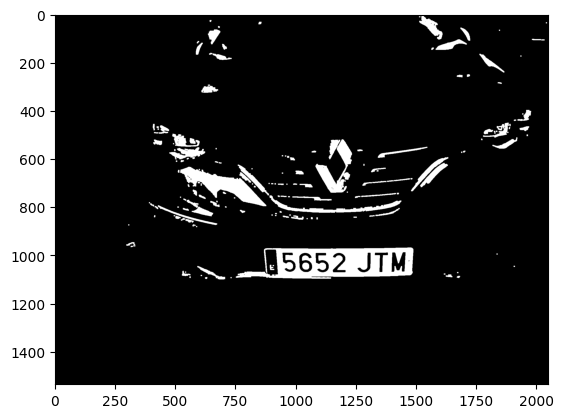

In [2]:

imagenes_edge_removed = []

for imagen in  imagenes:
    
    median = cv.medianBlur(imagen, 3)
    ret, th = cv.threshold(median, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
    kernel = np.ones((5,5), np.uint8)
    opening = cv.morphologyEx(th, cv.MORPH_OPEN, kernel)
    edge_touching_removed = clear_border(opening)
    contours, hierarchy = cv.findContours(edge_touching_removed, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    imagenes_edge_removed.append(edge_touching_removed)

#median = cv.medianBlur(img_gris, 3)
#ret, th = cv.threshold(median, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
#kernel = np.ones((5,5), np.uint8)
#opening = cv.morphologyEx(th, cv.MORPH_OPEN, kernel)
#edge_touching_removed = clear_border(opening)
#contours, hierarchy = cv.findContours(edge_touching_removed, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

plt.imshow(imagenes_edge_removed[15], cmap="gray")

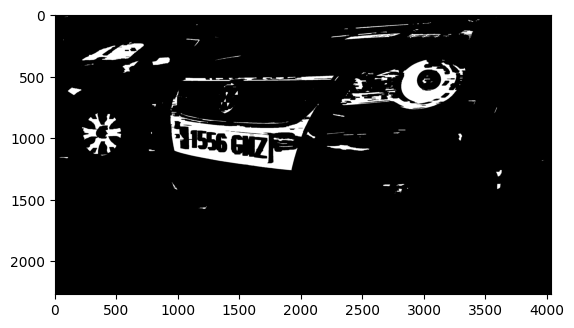

In [3]:
#quitar linias finas elemento que cauan problemas
imagen_opening = []

for imagen in  imagenes_edge_removed:

    median = cv.medianBlur(imagen, 3)
    ret, th = cv.threshold(median, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
    kernel = np.ones((3,3), np.uint8)
    img_erosion = cv.erode(th, kernel, iterations=4)
    opening = cv.morphologyEx(th, cv.MORPH_ERODE,  np.ones((1,30), np.uint8))
    imagen_opening.append(opening)


plt.imshow(imagen_opening[0], cmap="gray")
#median = cv.medianBlur(imagen, 3)
#ret, th = cv.threshold(median, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
#kernel = np.ones((3,3), np.uint8)0
#img_erosion = cv.erode(th, kernel, iterations=4)
#opening = cv.morphologyEx(th, cv.MORPH_ERODE,  np.ones((1,30), np.uint8))
#imagen_opening.append(opening)

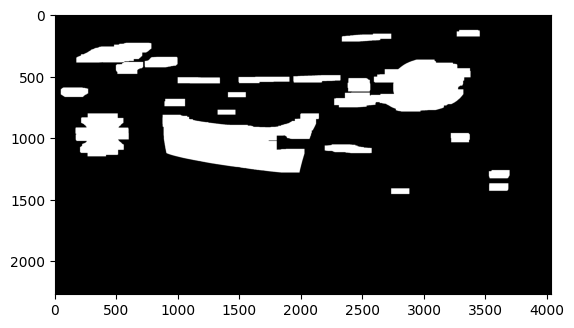

In [4]:

imagenes_cnt = []

for imagen in imagen_opening:
    
    img_erosion = cv.erode(imagen, kernel, iterations=7)
    img_dilation = cv.dilate(img_erosion, kernel, iterations=7)
    img_dilation = cv.dilate(img_dilation, np.ones((2,9), np.uint8), iterations=15)
    img_dilation = cv.dilate(img_dilation, kernel, iterations=5)



    contour,hier = cv.findContours(img_dilation,cv.RETR_CCOMP,cv.CHAIN_APPROX_SIMPLE)

    for cnt in contour:
        cv.drawContours(img_dilation,[cnt],0,255,-1)

    gray = cv.bitwise_not(img_dilation)



    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(3,3))
    res = cv.morphologyEx(gray,cv.MORPH_OPEN,kernel)
    res = cv.bitwise_not(res)
    
    imagenes_cnt.append(res)

plt.imshow(imagenes_cnt[0], cmap="gray")


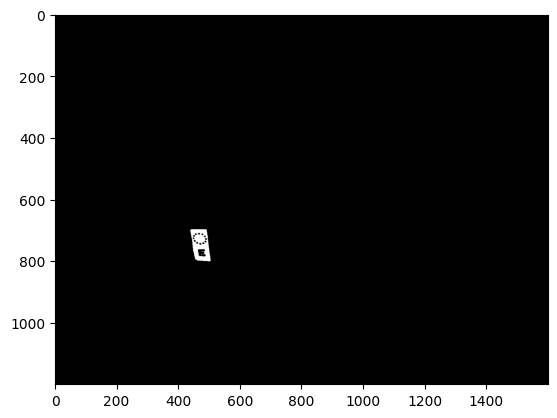

In [5]:
#aqui canvia el codi:

plt.imshow(imagenes_b[30], cmap="gray")

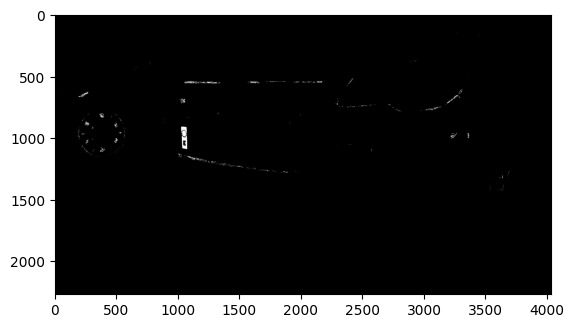

In [6]:
plt.imshow(imagenes_b[0]*imagenes_cnt[0], cmap="gray")

In [7]:
imagenes_combinadas=[]
for image_c,image_b in zip(imagenes_cnt,imagenes_b):
    comb=image_c*image_b
    comb = cv.erode(comb, kernel, iterations=5)
    comb = cv.dilate(comb, kernel, iterations=5)
    comb = cv.erode(comb, kernel, iterations=5)
    comb = cv.dilate(comb, kernel, iterations=5)
    #comb = cv.dilate(comb, np.ones((2,9), np.uint8), iterations=15)
    #comb = cv.dilate(comb, kernel, iterations=5)
    imagenes_combinadas.append(comb)
    

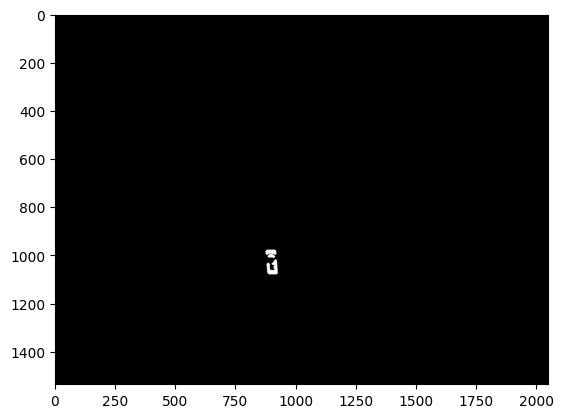

In [8]:
plt.imshow(imagenes_combinadas[15], cmap="gray")

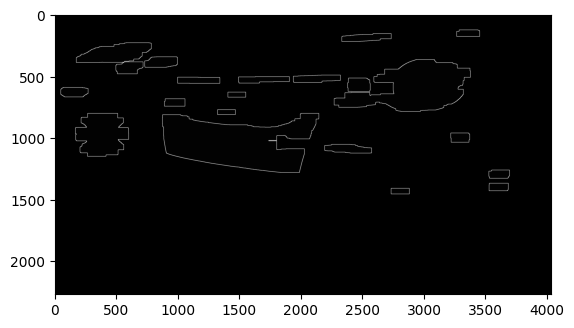

In [9]:
ll_cnts = []
ll_contornos = []

for imagen in imagenes_cnt:

    cnts,_=cv.findContours(cv.Canny(imagen,100,200),cv.RETR_LIST,cv.CHAIN_APPROX_SIMPLE)
    contornos =  cv.drawContours((imagen//255),cnts,-1,(100,100,100),2)
    ll_cnts.append(cnts)
    ll_contornos.append(contornos)
    
plt.imshow(ll_contornos[0], cmap="gray")

In [10]:
matricula_controno = []


for imagen,b in zip(ll_cnts,imagenes_combinadas):
    
    contornos_millor=imagen[0]
    area_max=0
    no_entrat=True
    for c in imagen:
        area = cv.contourArea(c)
        coord = cv.boundingRect(c)
        imagen_recortada = b[coord[1]:coord[1]+coord[3],coord[0]:coord[0]+coord[2]]
        
        if np.sum(imagen_recortada)>0 and area>area_max:#len(approx)==4 and area>4000:
            area_max=area
            contornos_millor=c
            no_entrat=False
    
    if no_entrat:     
        area_max=0
        for c in imagen:
            area = cv.contourArea(c)
            coord = cv.boundingRect(c)
            imagen_recortada = b[coord[1]:coord[1]+coord[3],coord[0]:coord[0]+coord[2]]
            
            if area>area_max:#len(approx)==4 and area>4000:
                area_max=area
                contornos_millor=c
            
    
    
    matricula_controno.append(contornos_millor)

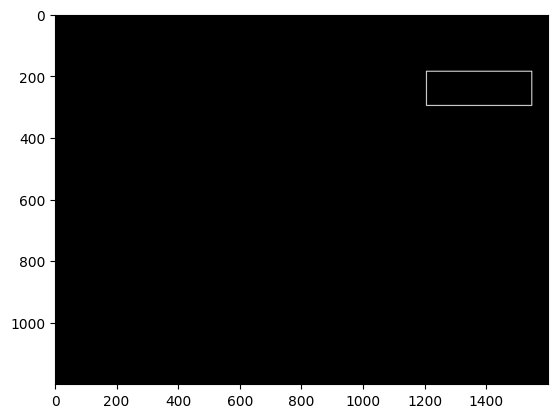

In [11]:
ll_matricula  = []
ll_coord = []
for i, imagen in enumerate(matricula_controno):

    epsilon = 0.02*cv.arcLength(imagen,True)
    approx = cv.approxPolyDP(imagen,epsilon,True)
    #print(len(approx))
    x,y,w,h = cv.boundingRect(approx)
    ll_coord.append((x,y,w,h))    
    img = ll_img[i]
    rec = cv.rectangle(img//255,(x,y),(x+w,y+h),(255,255,255),2)
    ll_matricula.append(rec)
    

plt.imshow(ll_matricula[32], cmap="gray")

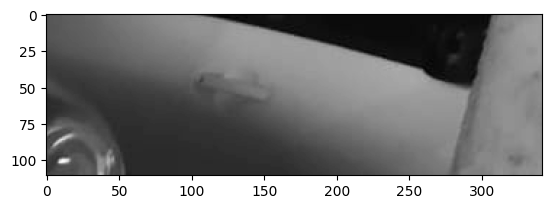

In [12]:
ll_recortadas = []

for  imagen, coord in zip(imagenes, ll_coord):
    
    imagen_recortada = imagen[coord[1]:coord[1]+coord[3],coord[0]:coord[0]+coord[2]]
    ll_recortadas.append(imagen_recortada)
    


plt.imshow(ll_recortadas[32],cmap="gray") 

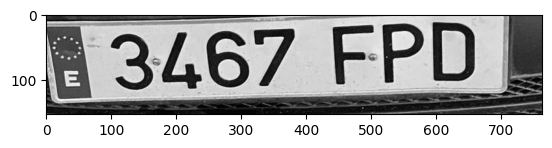

In [13]:
plt.imshow(ll_recortadas[20],cmap="gray") 

In [14]:
def comprovador(texte):
    if len(texte)==7:
        if texte[0] in ("1234567890"):
            if texte[1] in ("1234567890"):
                if texte[2] in ("1234567890"):
                    if texte[3] in ("1234567890"):
                        if texte[4] in ("WRTYPSDFGHJKLZXCVBNM"):
                            if texte[5] in ("WRTYPSDFGHJKLZXCVBNM"):
                                if texte[6] in ("WRTYPSDFGHJKLZXCVBNM"):
                                    return True
    return False
    #comprova que esta be
    

In [34]:
def netejar_lectura(ll_text, matricula_bona=False):
    
    ll_resultat = []

    for text in ll_text:
        #separa per \n ?
         #identificar el punt mig entre nombres i lletres
         # tirar cap a la esquerra i dreta
         # comprovar

        
        uncleared_ll = list(text.lower())
        ll=[]
        for l in uncleared_ll:
            if l in ("1234567890wrtypsdfghjklzxcvbnm"):
                ll.append(l)
        
        mitjos=[]
        for (x,letra) in enumerate(ll[:-1]):
            if letra in ("1234567890")and x<len(ll):
                if ll[x+1] in ("wrtypsdfghjklzxcvbnm"):
                    mitjos.append(x)

        for punt in mitjos:
            try:
                if ll[x-1] in ("1234567890"):
                    if ll[x-2] in ("1234567890"):
                        if ll[x-3] in ("1234567890"):
                            if ll[x+2] in ("wrtypsdfghjklzxcvbnm"):
                                if ll[x+3] in ("wrtypsdfghjklzxcvbnm"):
                                    matricula_bona=True
                                    matricula=ll[x-3:x+4].upper()
            except IndexError:
                pass
                #pass

        if not matricula_bona:
            count = 0
            ll = list(text.lower())
            matricula = ""

            for letra in ll:
                if count < 4:
                    if letra in ("1234567890"):
                        count += 1
                        matricula += letra
                    else:
                        count = 0
                elif count < 7:
                    if letra in ("wrtypsdfghjklzxcvbnm"):
                        count += 1
                        matricula += letra.upper()
              


        ll_resultat.append(matricula)
    return ll_resultat

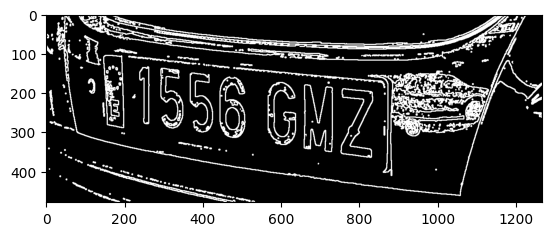

In [16]:
ll_contornos_pequeño = []
cnt_pequeño = []

for  imagen in ll_recortadas:
    bi_matricula1, bi_matricula = cv.threshold(imagen, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
    cnts_pequeño,_=cv.findContours(cv.Canny(bi_matricula,100,200),cv.RETR_LIST,cv.CHAIN_APPROX_SIMPLE)
    contornos_pequeño =  cv.drawContours((imagen//255),cnts_pequeño,-1,(100,100,100),2)
    ll_contornos_pequeño.append(contornos_pequeño)
    cnt_pequeño.append(cnts_pequeño)
    
plt.imshow(ll_contornos_pequeño[0], cmap="gray")

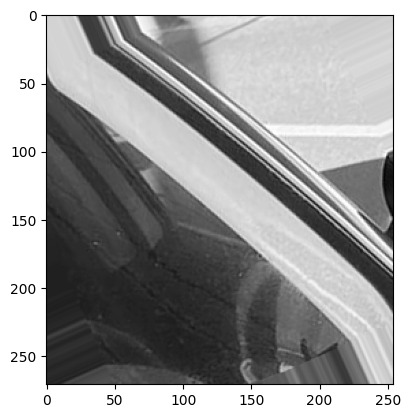

In [17]:
ll_rotated = []

for  imagen_recortada in ll_recortadas:
    
    gray = cv.bitwise_not(imagen_recortada)
    thresh = cv.threshold(gray, 0, 255,	cv.THRESH_BINARY | cv.THRESH_OTSU)[1]
    thresh = 255 - thresh
    

    cnts,_=cv.findContours(cv.Canny(thresh,100,200),cv.RETR_LIST,cv.CHAIN_APPROX_SIMPLE)
    contornos_millor=cnts[0]
    area_max=0
    for c in cnts:
        area = cv.contourArea(c)
        if area>area_max:#len(approx)==4 and area>4000:
            area_max=area
            contornos_millor=c
            
    angle  = cv.minAreaRect(contornos_millor)[-1]

    if angle < -45:
        angle =  (90 + angle)
        
    
    else:
        angle = -( 90 - angle)
        

    (h, w) = imagen_recortada.shape[:2]
    center = (w // 2, h // 2)
    M = cv.getRotationMatrix2D(center, -angle, 1.0)
    rotated = cv.warpAffine(imagen_recortada, M, (w, h), flags=cv.INTER_CUBIC, borderMode=cv.BORDER_REPLICATE)
    
    ll_rotated.append(rotated)
 
plt.imshow(ll_rotated[25],cmap="gray")

In [19]:
import pytesseract
#pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract'
pytesseract.pytesseract.tesseract_cmd = 'C:/Program Files/Tesseract-OCR/tesseract'

In [20]:
ll_text = []

for img_rotated in ll_rotated:
    text = pytesseract.image_to_string(img_rotated,config='--psm 11')
    ll_text.append(text)
    
    

print('PLACA: ',ll_text[0])

PLACA:  Mists:

—

Op cao

Za

@

11556 G

MZ

——



In [28]:
def girar(imagen_recortada):

    gray = cv.bitwise_not(imagen_recortada)
    thresh = cv.threshold(gray, 0, 255,	cv.THRESH_BINARY | cv.THRESH_OTSU)[1]
    thresh = 255 - thresh
    

    cnts,_=cv.findContours(cv.Canny(thresh,100,200),cv.RETR_LIST,cv.CHAIN_APPROX_SIMPLE)
    contornos_millor=cnts[0]
    area_max=0
    for c in cnts:
        area = cv.contourArea(c)
        if area>area_max:#len(approx)==4 and area>4000:
            area_max=area
            contornos_millor=c
            
    angle  = cv.minAreaRect(contornos_millor)[-1]

    if angle < -45:
        angle =  (90 + angle)
        
    
    else:
        angle = -( 90 - angle)
        

    (h, w) = imagen_recortada.shape[:2]
    center = (w // 2, h // 2)
    M = cv.getRotationMatrix2D(center, -angle, 1.0)
    rotated = cv.warpAffine(imagen_recortada, M, (w, h), flags=cv.INTER_CUBIC, borderMode=cv.BORDER_REPLICATE)
    return rotated

In [35]:
ll_resultat = netejar_lectura(ll_text, matricula_bona=False)
a_girar=[]
index=0
for resultat,imatge in zip(ll_resultat,ll_recortadas):
    if not comprovador(resultat):
        girada=girar(imatge)#girar imatge
        text = pytesseract.image_to_string(girada,config='--psm 11')#llegir
        text_netejat=netejar_lectura([text], matricula_bona=False)[0]#netejar
        if comprovador(text_netejat):#compara
            ll_resultat[index]=text_netejat#substituiir si millor
        elif len(text_netejat)>len(resultat):#compara
            ll_resultat[index]=text_netejat#substituiir si millor
        else:
            pass   
    index+=1


In [36]:
ll_resultat

['1155GMZ',
 '182',
 '3044JMB',
 '923',
 '8366CRT',
 '4234KP',
 '0907JRF',
 '4',
 '',
 '9912HL',
 '8771MV',
 '',
 '',
 '',
 '1236',
 '',
 '0214JWP',
 '6603DZM',
 '',
 '',
 '72',
 '9879GYS',
 '6484KHP',
 '1062',
 '8194GFW',
 '',
 '8278KTT',
 '47968ZC',
 '2254HZL',
 '',
 '8367GXN',
 '',
 '',
 '1146',
 '',
 '',
 '3044',
 '89575LCM',
 '350']

In [ ]:
#girar fotos a girar 
#refer les que san de girar
# amb text = pytesseract.image_to_string(img_rotated,config='--psm 11')
#substituir el texte llegit originalment
#netejar netejar_lectura(ll_text, matricula_bona=True)
#i ja nomes queda mirar que surt.

In [ ]:
dic_y = {'2': '8425MFR', '3':'2736LFT', '4':'5534HWK', '10':'1556GMZ', '11':'0182GLK', '12':'3044JMB', '13':'6929LKK',
  '14':'3660CRT', '15':'2344KJP', '16':'0907JRF', '17':'6401JBX', '18':'4674FHC', '20':'0012HLY', '21':'7713MFV'
  , '22':'8234MHS', '23':'1087MDR', '24':'3641JGY', '25':'4236KMV', '26':'5652JTM', '27':'0214JWP', '28':'6603DZM', 
  '29':'9058GMF', '30':'3467FPD', '32':'8798GYS', '33':'4840KHP', '34':'1062FNT', '35':'1943GFW', '36':'2376CHN'
  , '37':'2780KTT', '38':'2968FZC', '39':'2254HZL', '40':'3678GXN', '41':'3396GDF', '42':'5317JVM', '43':'4146HXM', 
  '44':'2304LSC', '45':'0424JLP', '46':'3044JMB', '47':'9575LCM', '48':'2354HKR'}

In [ ]:
path = os.getcwd()+"\\Imatges"
nom_imagenes = os.listdir(path)
ll_y = []
ll_titulos = []

for titulo in nom_imagenes:
    
    if titulo.endswith('.jpg') or titulo.endswith('.jpeg'):
        ll_titulos.append(titulo)
        img =  cv.imread('Imatges/' + titulo)
        ll_y.append(img)

In [ ]:
key = list(dic_y.keys())
key.sort()
ll_errores = []

for k, result in zip(key, ll_resultat):
    
    errores = 0
    for lletra_res, lletra_real in zip(result, dic_y[k]):
        if lletra_res != lletra_real:
            errores += 1
    ll_errores.append(errores)
print(ll_resultat)
print(ll_errores)

['1155GMZ', '182    ', '3044JMB', '923    ', '8366CRT', '4234KP ', '0907JRF', '4      ', '       ', '9912HL ', '8771MV ', '       ', '       ', '       ', '1236   ', '       ', '0214JWP', '6603DZMFTNNCR', '       ', '       ', '72     ', '9879GYS', '6484KHP', '1062L  ', '8194GFW', '       ', '8278KTT', '47968ZC', '2254HZL', '       ', '8367GXN', '       ', '       ', '1146   ', '       ', '       ', '3044   ', '8957LCM', '350    ']
[2, 7, 0, 7, 3, 5, 0, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 5, 7, 7, 7, 7, 7, 7, 7, 6, 7, 6]
